In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **With** **Oversample**

## **Machine Learning**

### **Importing Libraries**

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM, Dense, MaxPooling1D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/opu/Emotion.csv")

In [ ]:
df.head()

,ID,Data,Love,Joy,Surprise,Anger,Sadness,Fear,Disgust,Hate,Topic,Domain,is_admin
0,5454.0,লকাল বাস ভালো এটা থেকে,0,0,0.0,0,1,0,0.0,0,Travel,Youtube,False
1,22549.0,কত অভিজানই তো চলে কিন্তু ওয়াসার পানির অভিজান ক...,0,0,0.0,0,1,0,0.0,0,Politics,Youtube,False
2,7033.0,বিয়ের মহল ছেড়ে তিনি বিস্রাম নিতে চলে যান (৬ ...,0,0,0.0,1,0,0,0.0,0,Personal,Facebook,False
3,21114.0,চাচাজি তো কেবল মাকে ধর্ষণ করেছেন,0,0,0.0,0,1,0,0.0,0,Education,Facebook,False
4,23683.0,সত্যিকার মানুষ তারাই ভাই,0,1,0.0,0,0,0,0.0,0,Personal,Youtube,False


In [ ]:
df.drop(columns=['ID', 'Topic', 'Domain', 'is_admin'], inplace=True)

In [ ]:
df.head()

,Data,Love,Joy,Surprise,Anger,Sadness,Fear,Disgust,Hate
0,লকাল বাস ভালো এটা থেকে,0,0,0.0,0,1,0,0.0,0
1,কত অভিজানই তো চলে কিন্তু ওয়াসার পানির অভিজান ক...,0,0,0.0,0,1,0,0.0,0
2,বিয়ের মহল ছেড়ে তিনি বিস্রাম নিতে চলে যান (৬ ...,0,0,0.0,1,0,0,0.0,0
3,চাচাজি তো কেবল মাকে ধর্ষণ করেছেন,0,0,0.0,0,1,0,0.0,0
4,সত্যিকার মানুষ তারাই ভাই,0,1,0.0,0,0,0,0.0,0


In [ ]:
for column in df.columns[1:-1]:
    count = (df[column] == 1).sum()
    print(f"{column}: {count}")

Love: 4588
Joy: 10112
Surprise: 1086
Anger: 4476
Sadness: 5681
Fear: 401
Disgust: 2068


In [ ]:
rows_to_remove = []
df['label'] = None
for index, row in df.iterrows():
    count_ones = 0
    label = None
    for column in df.columns[1:]:
        if row[column] == 1:
            count_ones += 1
            label = column
            if count_ones > 1:
                rows_to_remove.append(index)
                break
    df.loc[index, 'label'] = label

df.drop(rows_to_remove, inplace=True)

In [ ]:
df.head()

,Data,Love,Joy,Surprise,Anger,Sadness,Fear,Disgust,Hate,label
0,লকাল বাস ভালো এটা থেকে,0,0,0.0,0,1,0,0.0,0,Sadness
1,কত অভিজানই তো চলে কিন্তু ওয়াসার পানির অভিজান ক...,0,0,0.0,0,1,0,0.0,0,Sadness
2,বিয়ের মহল ছেড়ে তিনি বিস্রাম নিতে চলে যান (৬ ...,0,0,0.0,1,0,0,0.0,0,Anger
3,চাচাজি তো কেবল মাকে ধর্ষণ করেছেন,0,0,0.0,0,1,0,0.0,0,Sadness
4,সত্যিকার মানুষ তারাই ভাই,0,1,0.0,0,0,0,0.0,0,Joy


In [ ]:
df['label'].value_counts()

label
Joy         7669
Sadness     4856
Anger       3435
Love        2279
Disgust     2068
Hate        1591
Surprise     744
Fear         233
Name: count, dtype: int64

In [ ]:
print('Total Data : ', df['Data'].shape)
print('Total Label : ', df['label'].shape)

Total Data :  (22875,)
Total Label :  (22875,)


In [ ]:
df.drop(columns=['Love', 'Joy', 'Surprise', 'Anger','Sadness','Fear','Disgust','Hate'], inplace=True)

In [ ]:
df.head()

,Data,label
0,লকাল বাস ভালো এটা থেকে,Sadness
1,কত অভিজানই তো চলে কিন্তু ওয়াসার পানির অভিজান ক...,Sadness
2,বিয়ের মহল ছেড়ে তিনি বিস্রাম নিতে চলে যান (৬ ...,Anger
3,চাচাজি তো কেবল মাকে ধর্ষণ করেছেন,Sadness
4,সত্যিকার মানুষ তারাই ভাই,Joy


In [ ]:
df['label'].unique()

array(['Sadness', 'Anger', 'Joy', 'Love', 'Surprise', 'Fear', 'Disgust',
       'Hate'], dtype=object)

###**Preprocessing**

1. Remove HTML tags
2. Remove URLs
3. Remove punctuation
4. Remove single-character words
5. Remove extra whitespaces
6. Remove digits
7. Remove Emoji

In [ ]:
import string
import re
def preprocess_text(text):

    text = re.sub('<[^<]+?>', '', text)
    text = re.sub(r'http\S+', '', text)
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    text = ' '.join([word for word in text.split() if len(word) > 1])
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\d+', '', text)
    text = text.strip()
    return text

df['Data'] = df['Data'].apply(lambda x: preprocess_text(x) if pd.notnull(x) else x)
print(df.head())

                                                Data    label
0                             লকাল বাস ভালো এটা থেকে  Sadness
1  কত অভিজানই তো চলে কিন্তু ওয়াসার পানির অভিজান ক...  Sadness
2  বিয়ের মহল ছেড়ে তিনি বিস্রাম নিতে চলে যান নং ...    Anger
3                   চাচাজি তো কেবল মাকে ধর্ষণ করেছেন  Sadness
4                           সত্যিকার মানুষ তারাই ভাই      Joy


In [ ]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U0001F700-\U0001F77F"  # alchemical symbols
                           u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                           u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                           u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                           u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                           u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
df['Data'] = df['Data'].apply(remove_emoji)
df.head()

,Data,label
0,লকাল বাস ভালো এটা থেকে,Sadness
1,কত অভিজানই তো চলে কিন্তু ওয়াসার পানির অভিজান ক...,Sadness
2,বিয়ের মহল ছেড়ে তিনি বিস্রাম নিতে চলে যান নং ...,Anger
3,চাচাজি তো কেবল মাকে ধর্ষণ করেছেন,Sadness
4,সত্যিকার মানুষ তারাই ভাই,Joy


### Oversample

In [ ]:
texts = df.drop('label', axis=1)
labels = df['label']
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(texts, labels)
print('Before sampling: ', Counter(labels))
print('After sampling: ', Counter(y_resampled))

Before sampling:  Counter({'Joy': 7669, 'Sadness': 4856, 'Anger': 3435, 'Love': 2279, 'Disgust': 2068, 'Hate': 1591, 'Surprise': 744, 'Fear': 233})
After sampling:  Counter({'Sadness': 7669, 'Anger': 7669, 'Joy': 7669, 'Love': 7669, 'Surprise': 7669, 'Fear': 7669, 'Disgust': 7669, 'Hate': 7669})


### Label Encode

In [ ]:
from sklearn.preprocessing import LabelEncoder
X = X_resampled['Data']
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_resampled)

### Data split (80:20)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(49081, 250) (12271, 250) (49081,) (12271,)


### **Function call for Accuracy, Classification Report, Confusion matrix**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import LabelEncoder

def evaluate_model(model, X_test, y_test, label_encoder):
    class_names = ['Angry', 'Disgust', 'Fear', 'Hate', 'Joy', 'Love', 'Sadness', 'Surprise']
    # Predictions
    y_pred = model.predict(X_test)

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.4f}')

    # Precision
    precision = precision_score(y_test, y_pred, average='weighted')
    print(f'Precision: {precision:.4f}')

    # Recall
    recall = recall_score(y_test, y_pred, average='weighted')
    print(f'Recall: {recall:.4f}')

    # F1-Score
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f'F1-Score: {f1:.4f}')

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')

    # Add labels to the confusion matrix
    tick_labels = label_encoder.classes_
    plt.xticks(np.arange(len(tick_labels)) + 0.5, tick_labels)
    plt.yticks(np.arange(len(tick_labels)) + 0.5, tick_labels)

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

###**Feature Extraction using TF-IDF**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train = tfidf_vectorizer.fit_transform(X_train)
X_test = tfidf_vectorizer.transform(X_test)

## **Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### Accuracy

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

y_pred = rf_classifier.predict(X_test)

precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("\nAccuracy Score:", accuracy_score(y_test, y_pred))
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy Score: 0.8373400700839377
Precision: 0.8346925017299378
Recall: 0.8373400700839377
F1 Score: 0.8357542425350697


### Classification report

In [ ]:
from sklearn.metrics import classification_report

class_names = ['Angry', 'Disgust', 'Fear', 'Hate', 'Joy', 'Love', 'Sadness', 'Surprise']
report = classification_report(y_test, y_pred, target_names=class_names)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

       Angry       0.81      0.79      0.80      1510
     Disgust       0.90      0.93      0.91      1530
        Fear       0.96      0.99      0.97      1532
        Hate       0.93      0.92      0.92      1527
         Joy       0.60      0.58      0.59      1541
        Love       0.83      0.86      0.84      1560
     Sadness       0.75      0.70      0.72      1514
    Surprise       0.91      0.93      0.92      1557

    accuracy                           0.84     12271
   macro avg       0.83      0.84      0.84     12271
weighted avg       0.83      0.84      0.84     12271



### Confusion matrix

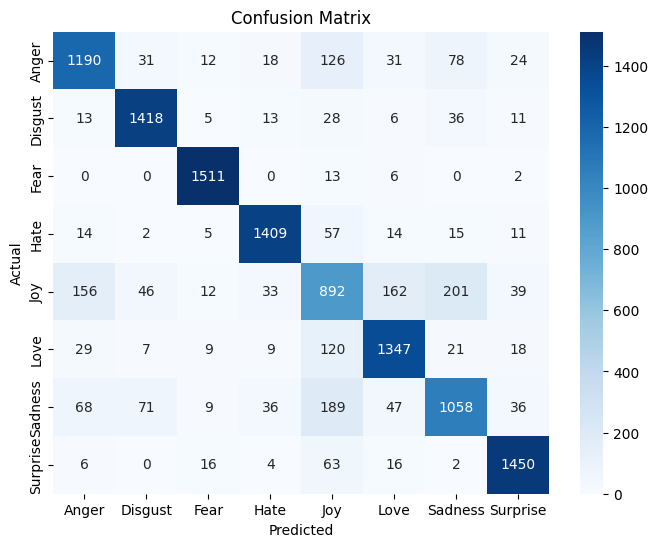

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')

tick_labels = label_encoder.classes_
plt.xticks(np.arange(len(tick_labels)) + 0.5, tick_labels)
plt.yticks(np.arange(len(tick_labels)) + 0.5, tick_labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### ROC

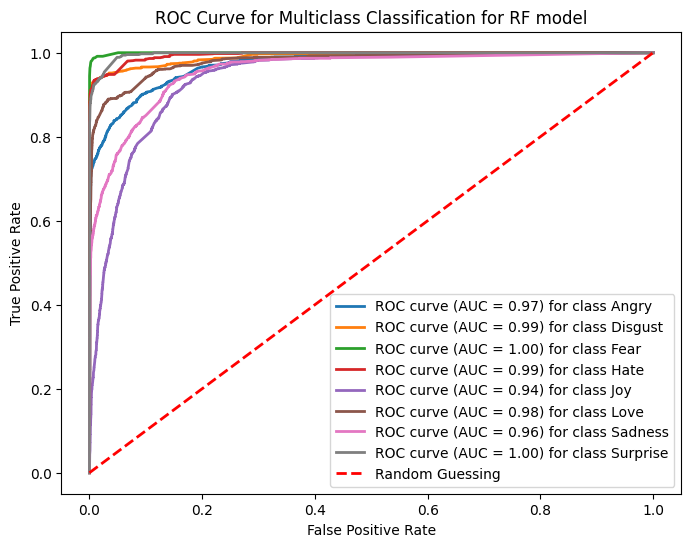

AUC Score for class Angry : 0.9711122024529342
AUC Score for class Disgust : 0.9905808358784036
AUC Score for class Fear : 0.9995595711879082
AUC Score for class Hate : 0.9949260298981695
AUC Score for class Joy : 0.9401201275118793
AUC Score for class Love : 0.9796112431744024
AUC Score for class Sadness : 0.9567772157578814
AUC Score for class Surprise : 0.9970132237137971


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr = {}
tpr = {}
roc_auc = {}
n_classes = len(class_names)

y_probs = rf_classifier.predict_proba(X_test)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (AUC = %0.2f) for class %s' % (roc_auc[i], class_names[i]))

plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification for RF model')
plt.legend(loc="lower right")
plt.show()

for i in range(n_classes):
    print("AUC Score for class", class_names[i], ":", roc_auc[i])

### Call function

Accuracy: 0.8373
Precision: 0.8347
Recall: 0.8373
F1-Score: 0.8358
Classification Report:
              precision    recall  f1-score   support

       Angry       0.81      0.79      0.80      1510
     Disgust       0.90      0.93      0.91      1530
        Fear       0.96      0.99      0.97      1532
        Hate       0.93      0.92      0.92      1527
         Joy       0.60      0.58      0.59      1541
        Love       0.83      0.86      0.84      1560
     Sadness       0.75      0.70      0.72      1514
    Surprise       0.91      0.93      0.92      1557

    accuracy                           0.84     12271
   macro avg       0.83      0.84      0.84     12271
weighted avg       0.83      0.84      0.84     12271



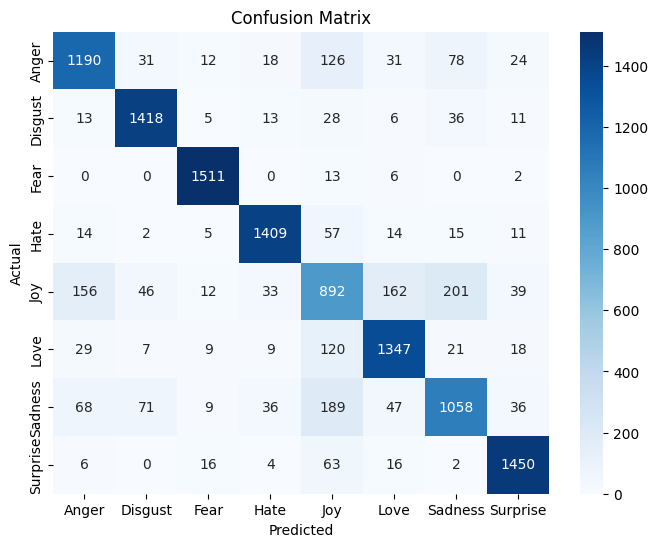

In [ ]:
evaluate_model(rf_classifier, X_test, y_test, label_encoder)

## **Decision Tree**

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

### Accuracy

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

y_pred = dt_classifier.predict(X_test)

precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("\nAccuracy Score:", accuracy_score(y_test, y_pred))
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy Score: 0.8113438187596773
Precision: 0.8019478411141725
Recall: 0.8113438187596773
F1 Score: 0.8049746727718147


### Classification report

In [ ]:
from sklearn.metrics import classification_report

class_names = ['Angry', 'Disgust', 'Fear', 'Hate', 'Joy', 'Love', 'Sadness', 'Surprise']
report = classification_report(y_test, y_pred, target_names=class_names)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

       Angry       0.78      0.78      0.78      1510
     Disgust       0.87      0.93      0.90      1530
        Fear       0.95      0.99      0.97      1532
        Hate       0.87      0.92      0.89      1527
         Joy       0.54      0.43      0.48      1541
        Love       0.78      0.86      0.82      1560
     Sadness       0.74      0.65      0.69      1514
    Surprise       0.88      0.93      0.90      1557

    accuracy                           0.81     12271
   macro avg       0.80      0.81      0.80     12271
weighted avg       0.80      0.81      0.80     12271



### Confusion matrix

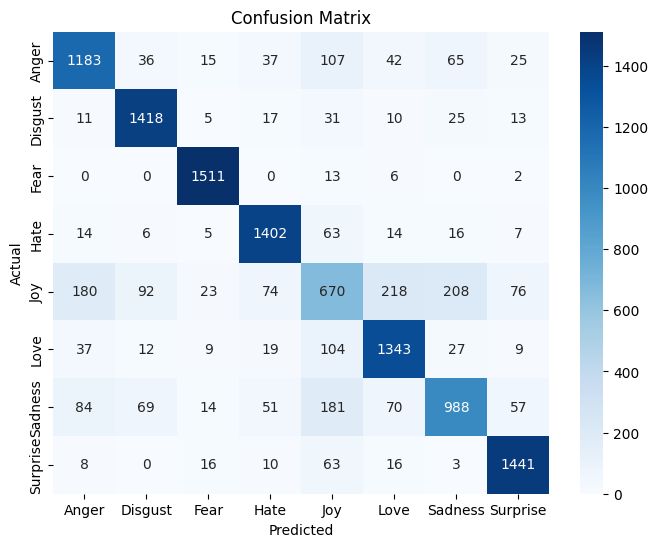

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')

tick_labels = label_encoder.classes_
plt.xticks(np.arange(len(tick_labels)) + 0.5, tick_labels)
plt.yticks(np.arange(len(tick_labels)) + 0.5, tick_labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### ROC

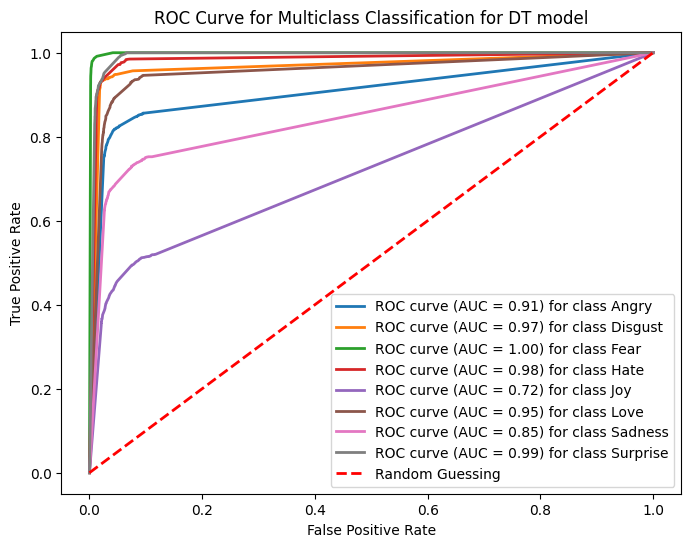

AUC Score for class Angry : 0.9067410768959039
AUC Score for class Disgust : 0.9670746385634912
AUC Score for class Fear : 0.99856638780541
AUC Score for class Hate : 0.9833032408457153
AUC Score for class Joy : 0.7201051652471466
AUC Score for class Love : 0.9549138017710047
AUC Score for class Sadness : 0.8474675456330916
AUC Score for class Surprise : 0.9923699613792313


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr = {}
tpr = {}
roc_auc = {}
n_classes = len(class_names)

y_probs = dt_classifier.predict_proba(X_test)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (AUC = %0.2f) for class %s' % (roc_auc[i], class_names[i]))

plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification for DT model')
plt.legend(loc="lower right")
plt.show()

for i in range(n_classes):
    print("AUC Score for class", class_names[i], ":", roc_auc[i])

### Call function

Accuracy: 0.8113
Precision: 0.8019
Recall: 0.8113
F1-Score: 0.8050
Classification Report:
              precision    recall  f1-score   support

       Angry       0.78      0.78      0.78      1510
     Disgust       0.87      0.93      0.90      1530
        Fear       0.95      0.99      0.97      1532
        Hate       0.87      0.92      0.89      1527
         Joy       0.54      0.43      0.48      1541
        Love       0.78      0.86      0.82      1560
     Sadness       0.74      0.65      0.69      1514
    Surprise       0.88      0.93      0.90      1557

    accuracy                           0.81     12271
   macro avg       0.80      0.81      0.80     12271
weighted avg       0.80      0.81      0.80     12271



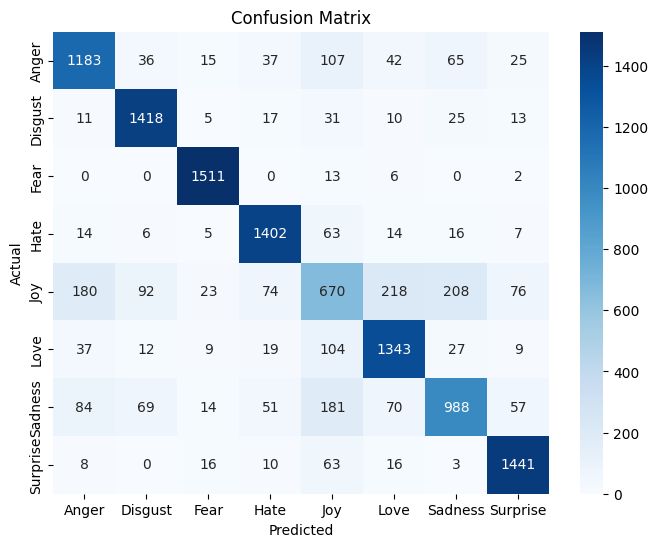

In [ ]:
evaluate_model(dt_classifier, X_test, y_test, label_encoder)

## **XGB boost**

In [ ]:
!pip install xgboost

In [ ]:
import xgboost as xgb

xgb_classifier = xgb.XGBClassifier(random_state=42)
xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

### Accuracy

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

y_pred = xgb_classifier.predict(X_test)

precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("\nAccuracy Score:", accuracy_score(y_test, y_pred))
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy Score: 0.6654714367207236
Precision: 0.6626594212629101
Recall: 0.6654714367207236
F1 Score: 0.6627605847294606


### Classification report

In [ ]:
from sklearn.metrics import classification_report

class_names = ['Angry', 'Disgust', 'Fear', 'Hate', 'Joy', 'Love', 'Sadness', 'Surprise']
report = classification_report(y_test, y_pred, target_names=class_names)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

       Angry       0.58      0.52      0.55      1510
     Disgust       0.73      0.70      0.71      1530
        Fear       0.93      0.98      0.95      1532
        Hate       0.72      0.76      0.74      1527
         Joy       0.40      0.45      0.43      1541
        Love       0.64      0.62      0.63      1560
     Sadness       0.54      0.46      0.50      1514
    Surprise       0.76      0.84      0.80      1557

    accuracy                           0.67     12271
   macro avg       0.66      0.66      0.66     12271
weighted avg       0.66      0.67      0.66     12271



### Confusion matrix

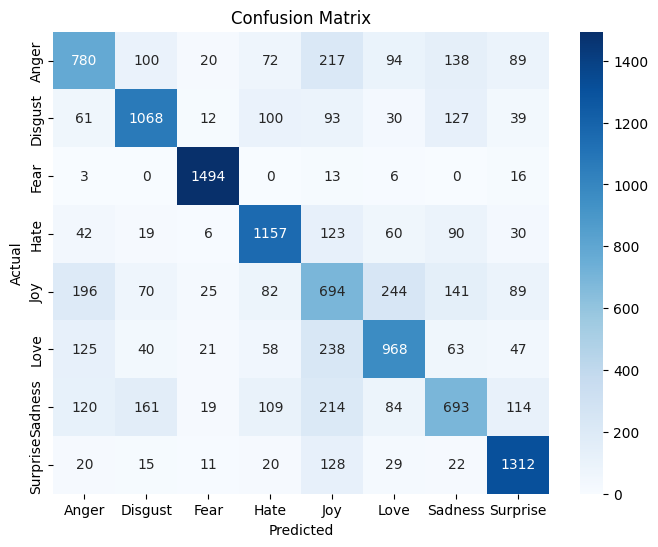

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')

tick_labels = label_encoder.classes_
plt.xticks(np.arange(len(tick_labels)) + 0.5, tick_labels)
plt.yticks(np.arange(len(tick_labels)) + 0.5, tick_labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### ROC

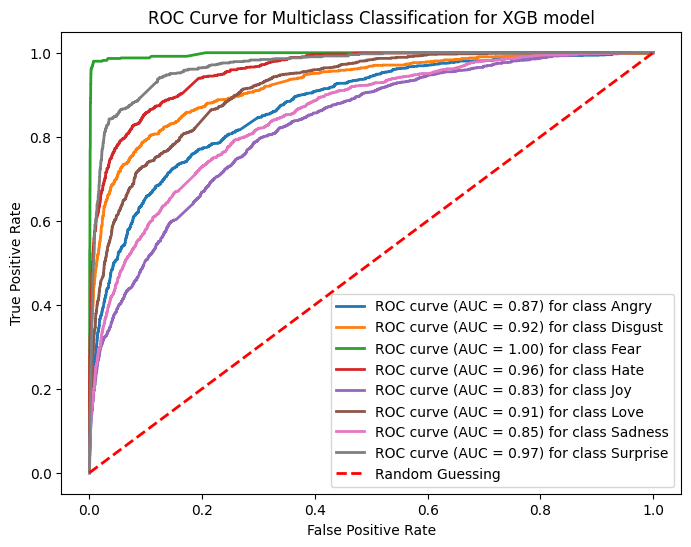

AUC Score for class Angry : 0.8725867755218593
AUC Score for class Disgust : 0.9222636918094675
AUC Score for class Fear : 0.9969149621070756
AUC Score for class Hate : 0.956816305020429
AUC Score for class Joy : 0.8255324032215438
AUC Score for class Love : 0.9142552647769248
AUC Score for class Sadness : 0.8509940809640222
AUC Score for class Surprise : 0.9690611831001856


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr = {}
tpr = {}
roc_auc = {}
n_classes = len(class_names)

y_probs = xgb_classifier.predict_proba(X_test)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (AUC = %0.2f) for class %s' % (roc_auc[i], class_names[i]))

plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification for XGB model')
plt.legend(loc="lower right")
plt.show()

for i in range(n_classes):
    print("AUC Score for class", class_names[i], ":", roc_auc[i])

### Call function

Accuracy: 0.6655
Precision: 0.6627
Recall: 0.6655
F1-Score: 0.6628
Classification Report:
              precision    recall  f1-score   support

       Angry       0.58      0.52      0.55      1510
     Disgust       0.73      0.70      0.71      1530
        Fear       0.93      0.98      0.95      1532
        Hate       0.72      0.76      0.74      1527
         Joy       0.40      0.45      0.43      1541
        Love       0.64      0.62      0.63      1560
     Sadness       0.54      0.46      0.50      1514
    Surprise       0.76      0.84      0.80      1557

    accuracy                           0.67     12271
   macro avg       0.66      0.66      0.66     12271
weighted avg       0.66      0.67      0.66     12271



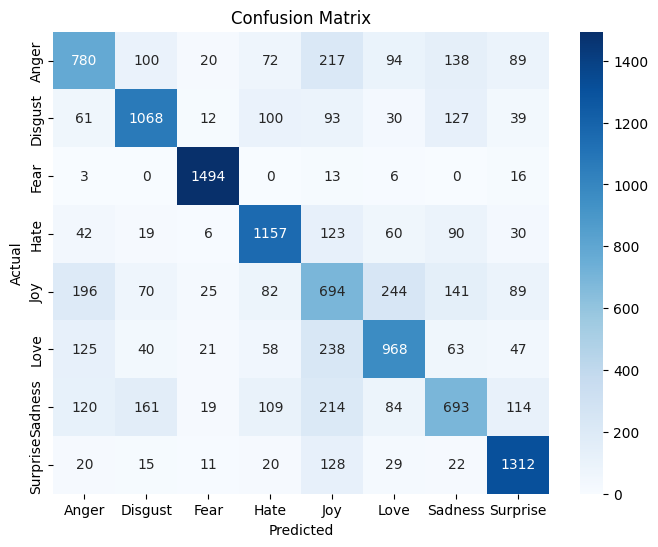

In [ ]:
evaluate_model(xgb_classifier, X_test, y_test, label_encoder)

## **MNB**

In [ ]:
from sklearn.naive_bayes import MultinomialNB

mnb_classifier = MultinomialNB()
mnb_classifier.fit(X_train, y_train)

MultinomialNB()

### Accuracy

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

y_pred = mnb_classifier.predict(X_test)

precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("\nAccuracy Score:", accuracy_score(y_test, y_pred))
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy Score: 0.5402982642001467
Precision: 0.5345810272769225
Recall: 0.5402982642001467
F1 Score: 0.5331510694364509


### Classification report

In [ ]:
from sklearn.metrics import classification_report

class_names = ['Angry', 'Disgust', 'Fear', 'Hate', 'Joy', 'Love', 'Sadness', 'Surprise']
report = classification_report(y_test, y_pred, target_names=class_names)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

       Angry       0.39      0.45      0.42      1510
     Disgust       0.56      0.53      0.54      1530
        Fear       0.63      0.83      0.72      1532
        Hate       0.61      0.70      0.65      1527
         Joy       0.46      0.35      0.40      1541
        Love       0.52      0.50      0.51      1560
     Sadness       0.50      0.37      0.43      1514
    Surprise       0.60      0.59      0.60      1557

    accuracy                           0.54     12271
   macro avg       0.53      0.54      0.53     12271
weighted avg       0.53      0.54      0.53     12271



### Confusion matrix

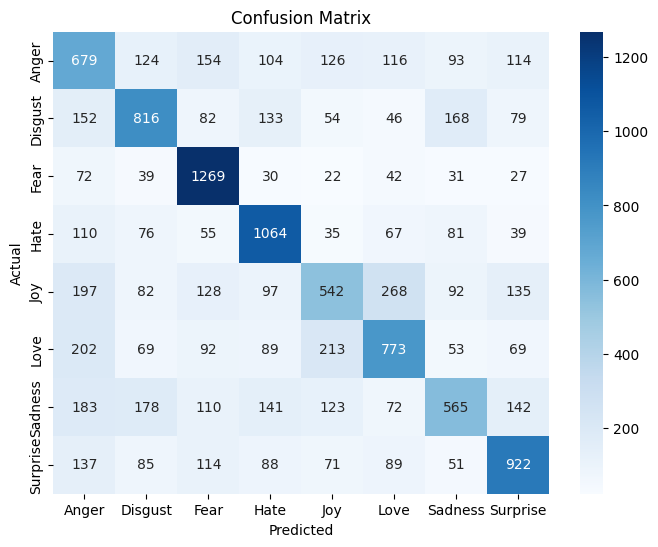

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')

tick_labels = label_encoder.classes_
plt.xticks(np.arange(len(tick_labels)) + 0.5, tick_labels)
plt.yticks(np.arange(len(tick_labels)) + 0.5, tick_labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### ROC

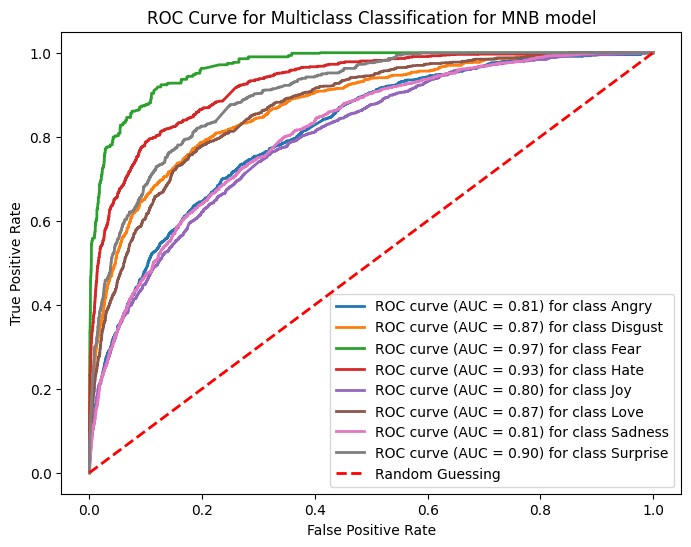

AUC Score for class Angry : 0.8117009793151748
AUC Score for class Disgust : 0.8730860857516827
AUC Score for class Fear : 0.9667288733361747
AUC Score for class Hate : 0.9260655251879668
AUC Score for class Joy : 0.7983856296942291
AUC Score for class Love : 0.8698332232140933
AUC Score for class Sadness : 0.8098268228522265
AUC Score for class Surprise : 0.9014767261702017


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr = {}
tpr = {}
roc_auc = {}
n_classes = len(class_names)

y_probs = mnb_classifier.predict_proba(X_test)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (AUC = %0.2f) for class %s' % (roc_auc[i], class_names[i]))

plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification for MNB model')
plt.legend(loc="lower right")
plt.show()

for i in range(n_classes):
    print("AUC Score for class", class_names[i], ":", roc_auc[i])

### Call function

Accuracy: 0.5403
Precision: 0.5346
Recall: 0.5403
F1-Score: 0.5332
Classification Report:
              precision    recall  f1-score   support

       Angry       0.39      0.45      0.42      1510
     Disgust       0.56      0.53      0.54      1530
        Fear       0.63      0.83      0.72      1532
        Hate       0.61      0.70      0.65      1527
         Joy       0.46      0.35      0.40      1541
        Love       0.52      0.50      0.51      1560
     Sadness       0.50      0.37      0.43      1514
    Surprise       0.60      0.59      0.60      1557

    accuracy                           0.54     12271
   macro avg       0.53      0.54      0.53     12271
weighted avg       0.53      0.54      0.53     12271



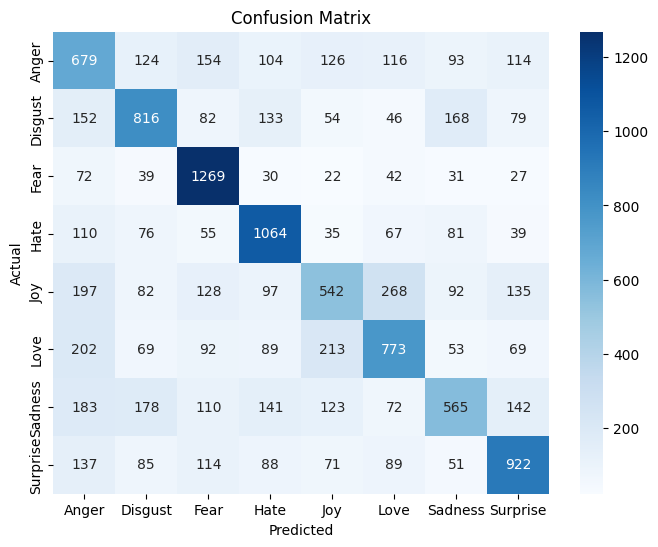

In [ ]:
evaluate_model(mnb_classifier, X_test, y_test, label_encoder)

## **GNB**

In [ ]:
from sklearn.naive_bayes import GaussianNB

gnb_classifier = GaussianNB()

gnb_classifier.fit(X_train.toarray(), y_train)

In [ ]:
y_pred_gnb = gnb_classifier.predict(X_test.toarray())

accuracy_gnb = accuracy_score(y_test, y_pred_gnb)
print(f'Gaussian Naive Bayes Accuracy: {accuracy_gnb:.4f}')


Gaussian Naive Bayes Accuracy: 0.3773


### Accuracy

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score


precision = precision_score(y_test, y_pred_gnb, average='weighted')
recall = recall_score(y_test, y_pred_gnb, average='weighted')
f1 = f1_score(y_test, y_pred_gnb, average='weighted')

print("\nAccuracy Score:", accuracy_score(y_test, y_pred_gnb))
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy Score: 0.3773123624806454
Precision: 0.5020105339102605
Recall: 0.3773123624806454
F1 Score: 0.3438942527561461


### Classification report

In [ ]:
from sklearn.metrics import classification_report

class_names = ['Angry', 'Disgust', 'Fear', 'Hate', 'Joy', 'Love', 'Sadness', 'Surprise']
report = classification_report(y_test, y_pred_gnb, target_names=class_names)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

       Angry       0.55      0.21      0.31      1510
     Disgust       0.87      0.31      0.45      1530
        Fear       0.26      1.00      0.42      1532
        Hate       0.59      0.48      0.53      1527
         Joy       0.37      0.03      0.06      1541
        Love       0.39      0.34      0.36      1560
     Sadness       0.65      0.12      0.20      1514
    Surprise       0.35      0.52      0.42      1557

    accuracy                           0.38     12271
   macro avg       0.50      0.38      0.34     12271
weighted avg       0.50      0.38      0.34     12271



### Confusion matrix

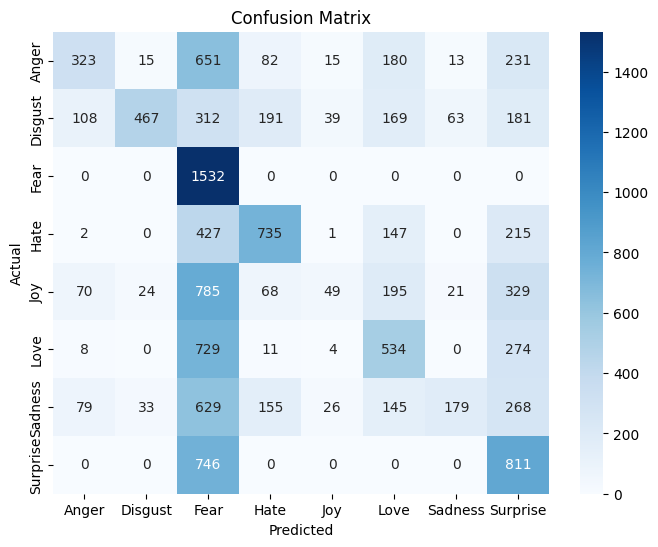

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_gnb)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')

tick_labels = label_encoder.classes_
plt.xticks(np.arange(len(tick_labels)) + 0.5, tick_labels)
plt.yticks(np.arange(len(tick_labels)) + 0.5, tick_labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### ROC

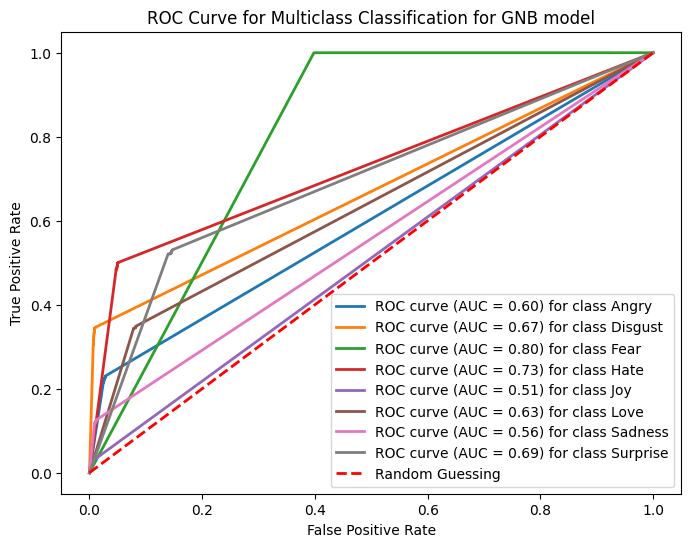

AUC Score for class Angry : 0.6011932961251417
AUC Score for class Disgust : 0.6683004710433967
AUC Score for class Fear : 0.800866002421082
AUC Score for class Hate : 0.7252372411997301
AUC Score for class Joy : 0.5112471598004951
AUC Score for class Love : 0.6337037888200244
AUC Score for class Sadness : 0.5568481474199651
AUC Score for class Surprise : 0.6930365541925049


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr = {}
tpr = {}
roc_auc = {}
n_classes = len(class_names)

y_probs = gnb_classifier.predict_proba(X_test.toarray())

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (AUC = %0.2f) for class %s' % (roc_auc[i], class_names[i]))

plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification for GNB model')
plt.legend(loc="lower right")
plt.show()

for i in range(n_classes):
    print("AUC Score for class", class_names[i], ":", roc_auc[i])

### Call function

Accuracy: 0.3773
Precision: 0.5020
Recall: 0.3773
F1-Score: 0.3439
Classification Report:
              precision    recall  f1-score   support

       Angry       0.55      0.21      0.31      1510
     Disgust       0.87      0.31      0.45      1530
        Fear       0.26      1.00      0.42      1532
        Hate       0.59      0.48      0.53      1527
         Joy       0.37      0.03      0.06      1541
        Love       0.39      0.34      0.36      1560
     Sadness       0.65      0.12      0.20      1514
    Surprise       0.35      0.52      0.42      1557

    accuracy                           0.38     12271
   macro avg       0.50      0.38      0.34     12271
weighted avg       0.50      0.38      0.34     12271



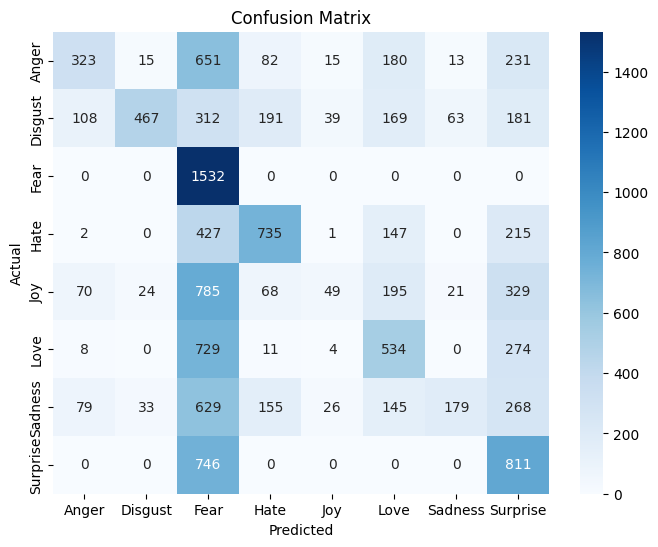

In [ ]:
evaluate_model(gnb_classifier, X_test.toarray(), y_test, label_encoder)

# Without Oversample

## **Machine Learning**

### **Importing Libraries**

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM, Dense, MaxPooling1D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.sequence import pad_sequences

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/opu/Emotion.csv")

In [ ]:
df.head()

,ID,Data,Love,Joy,Surprise,Anger,Sadness,Fear,Disgust,Hate,Topic,Domain,is_admin
0,5454.0,লকাল বাস ভালো এটা থেকে,0,0,0.0,0,1,0,0.0,0,Travel,Youtube,False
1,22549.0,কত অভিজানই তো চলে কিন্তু ওয়াসার পানির অভিজান ক...,0,0,0.0,0,1,0,0.0,0,Politics,Youtube,False
2,7033.0,বিয়ের মহল ছেড়ে তিনি বিস্রাম নিতে চলে যান (৬ ...,0,0,0.0,1,0,0,0.0,0,Personal,Facebook,False
3,21114.0,চাচাজি তো কেবল মাকে ধর্ষণ করেছেন,0,0,0.0,0,1,0,0.0,0,Education,Facebook,False
4,23683.0,সত্যিকার মানুষ তারাই ভাই,0,1,0.0,0,0,0,0.0,0,Personal,Youtube,False


In [ ]:
df.drop(columns=['ID', 'Topic', 'Domain', 'is_admin'], inplace=True)

In [ ]:
df.head()

,Data,Love,Joy,Surprise,Anger,Sadness,Fear,Disgust,Hate
0,লকাল বাস ভালো এটা থেকে,0,0,0.0,0,1,0,0.0,0
1,কত অভিজানই তো চলে কিন্তু ওয়াসার পানির অভিজান ক...,0,0,0.0,0,1,0,0.0,0
2,বিয়ের মহল ছেড়ে তিনি বিস্রাম নিতে চলে যান (৬ ...,0,0,0.0,1,0,0,0.0,0
3,চাচাজি তো কেবল মাকে ধর্ষণ করেছেন,0,0,0.0,0,1,0,0.0,0
4,সত্যিকার মানুষ তারাই ভাই,0,1,0.0,0,0,0,0.0,0


In [ ]:
for column in df.columns[1:-1]:
    count = (df[column] == 1).sum()
    print(f"{column}: {count}")

Love: 4588
Joy: 10112
Surprise: 1086
Anger: 4476
Sadness: 5681
Fear: 401
Disgust: 2068


In [ ]:
rows_to_remove = []
df['label'] = None
for index, row in df.iterrows():
    count_ones = 0
    label = None
    for column in df.columns[1:]:
        if row[column] == 1:
            count_ones += 1
            label = column
            if count_ones > 1:
                rows_to_remove.append(index)
                break
    df.loc[index, 'label'] = label

df.drop(rows_to_remove, inplace=True)

In [ ]:
df.head()

,Data,Love,Joy,Surprise,Anger,Sadness,Fear,Disgust,Hate,label
0,লকাল বাস ভালো এটা থেকে,0,0,0.0,0,1,0,0.0,0,Sadness
1,কত অভিজানই তো চলে কিন্তু ওয়াসার পানির অভিজান ক...,0,0,0.0,0,1,0,0.0,0,Sadness
2,বিয়ের মহল ছেড়ে তিনি বিস্রাম নিতে চলে যান (৬ ...,0,0,0.0,1,0,0,0.0,0,Anger
3,চাচাজি তো কেবল মাকে ধর্ষণ করেছেন,0,0,0.0,0,1,0,0.0,0,Sadness
4,সত্যিকার মানুষ তারাই ভাই,0,1,0.0,0,0,0,0.0,0,Joy


In [ ]:
df['label'].value_counts()

label
Joy         7669
Sadness     4856
Anger       3435
Love        2279
Disgust     2068
Hate        1591
Surprise     744
Fear         233
Name: count, dtype: int64

In [ ]:
print('Total Data : ', df['Data'].shape)
print('Total Label : ', df['label'].shape)

Total Data :  (22875,)
Total Label :  (22875,)


In [ ]:
df.drop(columns=['Love', 'Joy', 'Surprise', 'Anger','Sadness','Fear','Disgust','Hate'], inplace=True)

In [ ]:
df.head()

,Data,label
0,লকাল বাস ভালো এটা থেকে,Sadness
1,কত অভিজানই তো চলে কিন্তু ওয়াসার পানির অভিজান ক...,Sadness
2,বিয়ের মহল ছেড়ে তিনি বিস্রাম নিতে চলে যান (৬ ...,Anger
3,চাচাজি তো কেবল মাকে ধর্ষণ করেছেন,Sadness
4,সত্যিকার মানুষ তারাই ভাই,Joy


In [ ]:
df['label'].unique()

array(['Sadness', 'Anger', 'Joy', 'Love', 'Surprise', 'Fear', 'Disgust',
       'Hate'], dtype=object)

### **Preprocessing**

1. Remove HTML tags
2. Remove URLs
3. Remove punctuation
4. Remove single-character words
5. Remove extra whitespaces
6. Remove digits
7. Remove Emoji

In [ ]:
import string
import re
def preprocess_text(text):

    text = re.sub('<[^<]+?>', '', text)
    text = re.sub(r'http\S+', '', text)
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    text = ' '.join([word for word in text.split() if len(word) > 1])
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\d+', '', text)
    text = text.strip()
    return text

df['Data'] = df['Data'].apply(lambda x: preprocess_text(x) if pd.notnull(x) else x)
print(df.head())

                                                Data    label
0                             লকাল বাস ভালো এটা থেকে  Sadness
1  কত অভিজানই তো চলে কিন্তু ওয়াসার পানির অভিজান ক...  Sadness
2  বিয়ের মহল ছেড়ে তিনি বিস্রাম নিতে চলে যান নং ...    Anger
3                   চাচাজি তো কেবল মাকে ধর্ষণ করেছেন  Sadness
4                           সত্যিকার মানুষ তারাই ভাই      Joy


In [ ]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U0001F700-\U0001F77F"  # alchemical symbols
                           u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                           u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                           u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                           u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                           u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
df['Data'] = df['Data'].apply(remove_emoji)
df.head()

,Data,label
0,লকাল বাস ভালো এটা থেকে,Sadness
1,কত অভিজানই তো চলে কিন্তু ওয়াসার পানির অভিজান ক...,Sadness
2,বিয়ের মহল ছেড়ে তিনি বিস্রাম নিতে চলে যান নং ...,Anger
3,চাচাজি তো কেবল মাকে ধর্ষণ করেছেন,Sadness
4,সত্যিকার মানুষ তারাই ভাই,Joy


### **Label Encode**

In [ ]:
X = df['Data']
y = df['label']

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(18300,) (4575,) (18300,) (4575,)


### **Function call for Accuracy, Classification Report, Confusion matrix, Roc**

In [ ]:
from sklearn.metrics import roc_curve, auc

def evaluate_model(model, X_test, y_test, label_encoder):
    # Predictions
    y_pred = model.predict(X_test)

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.4f}')

    # Precision
    precision = precision_score(y_test, y_pred, average='weighted')
    print(f'Precision: {precision:.4f}')

    # Recall
    recall = recall_score(y_test, y_pred, average='weighted')
    print(f'Recall: {recall:.4f}')

    # F1-Score
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f'F1-Score: {f1:.4f}')

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    tick_labels = label_encoder.classes_
    plt.xticks(np.arange(len(tick_labels)) + 0.5, tick_labels)
    plt.yticks(np.arange(len(tick_labels)) + 0.5, tick_labels)

    plt.figure()
    # Plot ROC curve
    plt.plot([0, 1], [0, 1], 'k--', color='gray', label='Random')
    y_pred_proba = model.predict_proba(X_test)
    for i in range(len(label_encoder.classes_)):
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, i], pos_label=i)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'ROC curve (class {label_encoder.classes_[i]}) (AUC = {roc_auc:.2f})')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")

    plt.tight_layout()
    plt.show()


###**Feature Extraction using TF-IDF**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_features = tfidf_vectorizer.fit_transform(X)

###**Data Split (80:20)**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, y, test_size=0.2, random_state=42)

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(18300,) (4575,) (18300,) (4575,)


## **Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

In [ ]:
y_pred = rf_classifier.predict(X_test)

print("\nAccuracy Score:", accuracy_score(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy Score: 0.4577049180327869

Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.26      0.32       711
           1       0.48      0.18      0.26       395
           2       0.25      0.02      0.04        45
           3       0.59      0.20      0.29       305
           4       0.49      0.78      0.60      1593
           5       0.45      0.15      0.23       462
           6       0.39      0.50      0.44       928
           7       0.21      0.07      0.10       136

    accuracy                           0.46      4575
   macro avg       0.41      0.27      0.29      4575
weighted avg       0.45      0.46      0.42      4575



### **Call Function Evaluate**

Accuracy: 0.4577
Precision: 0.4519
Recall: 0.4577
F1-Score: 0.4176
Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.26      0.32       711
           1       0.48      0.18      0.26       395
           2       0.25      0.02      0.04        45
           3       0.59      0.20      0.29       305
           4       0.49      0.78      0.60      1593
           5       0.45      0.15      0.23       462
           6       0.39      0.50      0.44       928
           7       0.21      0.07      0.10       136

    accuracy                           0.46      4575
   macro avg       0.41      0.27      0.29      4575
weighted avg       0.45      0.46      0.42      4575



<ipython-input-20-5382da4f21a8>:42: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='gray', label='Random')


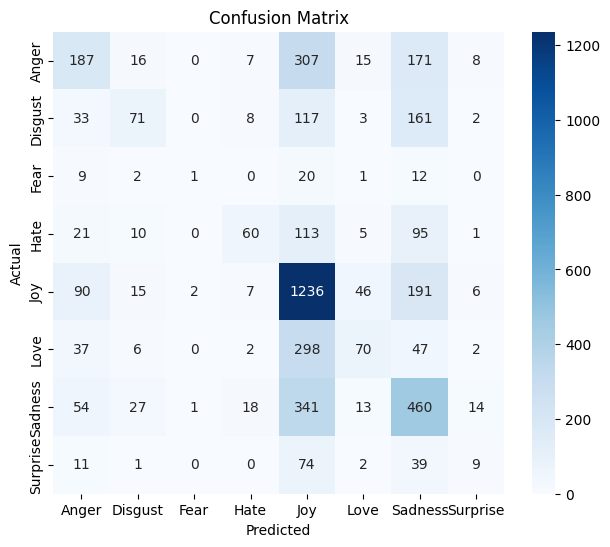

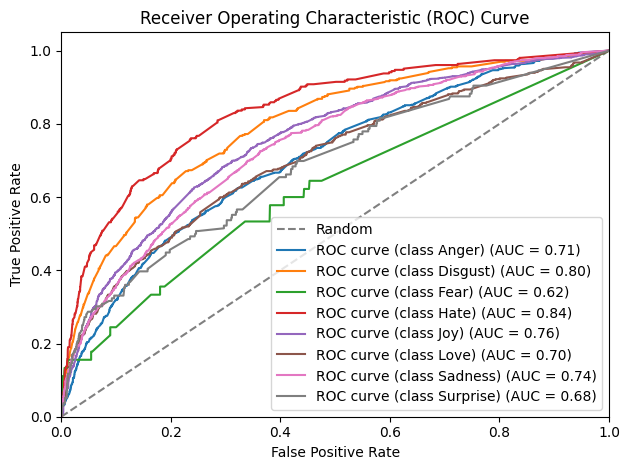

In [ ]:
evaluate_model(rf_classifier, X_test, y_test, label_encoder)

## **Decision Tree**

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)

In [ ]:
y_pred = dt_classifier.predict(X_test)

accuracy_dt = accuracy_score(y_test, y_pred)
print("\nDecision Tree Accuracy Score:", accuracy_dt)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Decision Tree Accuracy Score: 0.3702732240437158

Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.24      0.25       711
           1       0.26      0.20      0.23       395
           2       0.10      0.07      0.08        45
           3       0.27      0.23      0.25       305
           4       0.49      0.58      0.53      1593
           5       0.27      0.19      0.22       462
           6       0.35      0.38      0.36       928
           7       0.12      0.08      0.10       136

    accuracy                           0.37      4575
   macro avg       0.26      0.25      0.25      4575
weighted avg       0.35      0.37      0.36      4575



### **Call Function Evaluate**

Accuracy: 0.3703
Precision: 0.3531
Recall: 0.3703
F1-Score: 0.3590
Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.24      0.25       711
           1       0.26      0.20      0.23       395
           2       0.10      0.07      0.08        45
           3       0.27      0.23      0.25       305
           4       0.49      0.58      0.53      1593
           5       0.27      0.19      0.22       462
           6       0.35      0.38      0.36       928
           7       0.12      0.08      0.10       136

    accuracy                           0.37      4575
   macro avg       0.26      0.25      0.25      4575
weighted avg       0.35      0.37      0.36      4575



<ipython-input-38-145de915995e>:42: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='gray', label='Random')


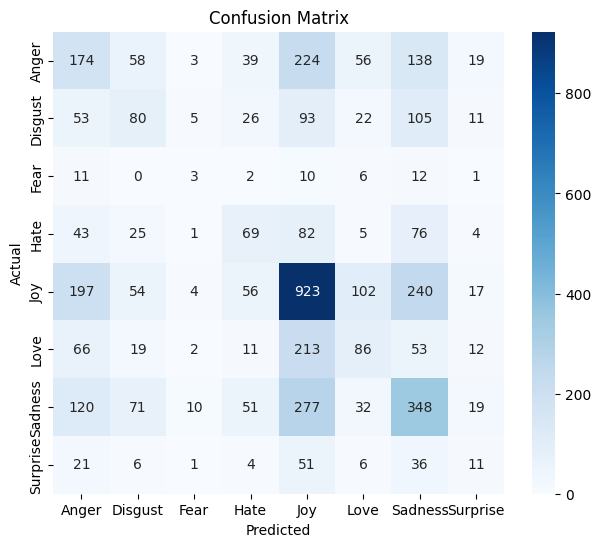

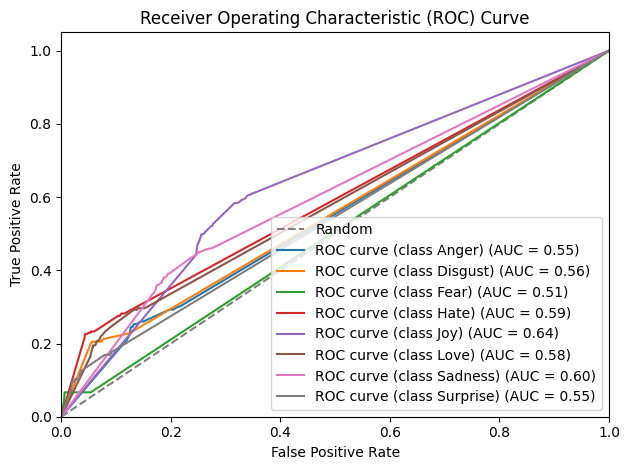

In [ ]:
evaluate_model(dt_classifier, X_test, y_test, label_encoder)

## **XGB boost**

In [ ]:
!pip install xgboost

In [ ]:
import xgboost as xgb

xgb_classifier = xgb.XGBClassifier(random_state=42)
xgb_classifier.fit(X_train, y_train)

In [ ]:
y_pred_xgb = xgb_classifier.predict(X_test)

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("\nXGBoost Accuracy Score:", accuracy_xgb)


XGBoost Accuracy Score: 0.46994535519125685


### **Call Function Evaluate**

Accuracy: 0.4699
Precision: 0.4585
Recall: 0.4699
F1-Score: 0.4299
Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.25      0.32       711
           1       0.41      0.25      0.31       395
           2       0.25      0.04      0.08        45
           3       0.64      0.32      0.43       305
           4       0.49      0.82      0.61      1593
           5       0.46      0.16      0.24       462
           6       0.43      0.42      0.42       928
           7       0.20      0.03      0.05       136

    accuracy                           0.47      4575
   macro avg       0.42      0.29      0.31      4575
weighted avg       0.46      0.47      0.43      4575



<ipython-input-38-145de915995e>:42: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='gray', label='Random')


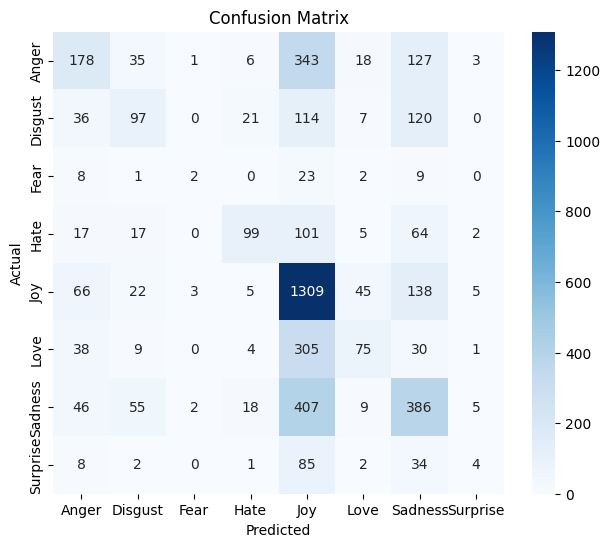

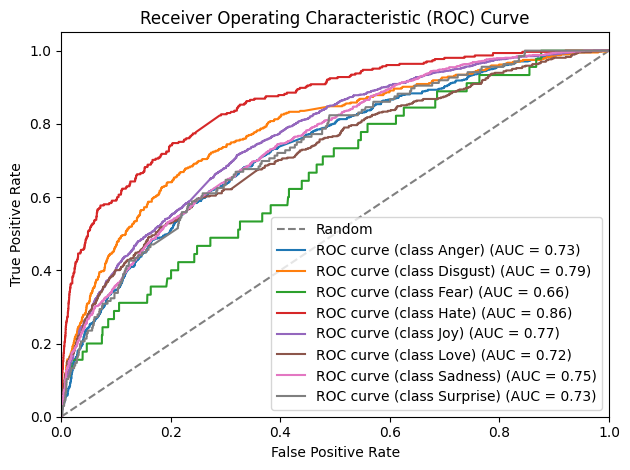

In [ ]:
evaluate_model(xgb_classifier, X_test, y_test, label_encoder)

## **MNB**

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

mnb_classifier = MultinomialNB()
mnb_classifier.fit(X_train, y_train)

In [ ]:
y_pred_mnb = mnb_classifier.predict(X_test)

accuracy_mnb = accuracy_score(y_test, y_pred_mnb)
print(f'Multinomial Naive Bayes Accuracy: {accuracy_mnb:.4f}')


Multinomial Naive Bayes Accuracy: 0.4361


### **Call Function Evaluate**

Accuracy: 0.4361
Precision: 0.4589
Recall: 0.4361
F1-Score: 0.3414
Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.14      0.23       711
           1       0.25      0.01      0.01       395
           2       0.00      0.00      0.00        45
           3       0.82      0.05      0.09       305
           4       0.43      0.91      0.59      1593
           5       0.63      0.04      0.08       462
           6       0.41      0.45      0.43       928
           7       0.00      0.00      0.00       136

    accuracy                           0.44      4575
   macro avg       0.39      0.20      0.18      4575
weighted avg       0.46      0.44      0.34      4575



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:13

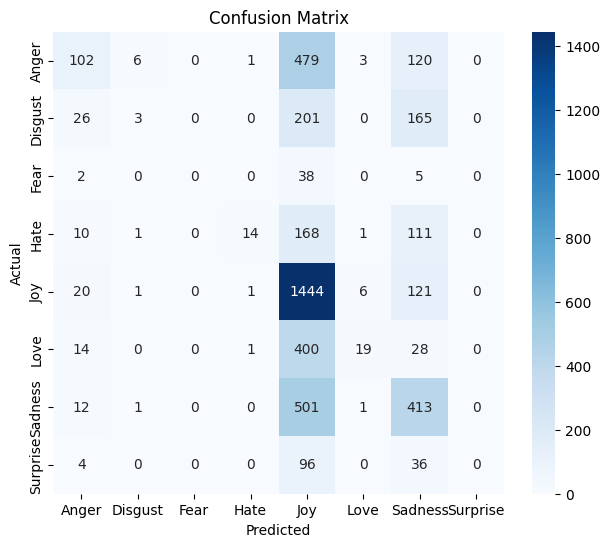

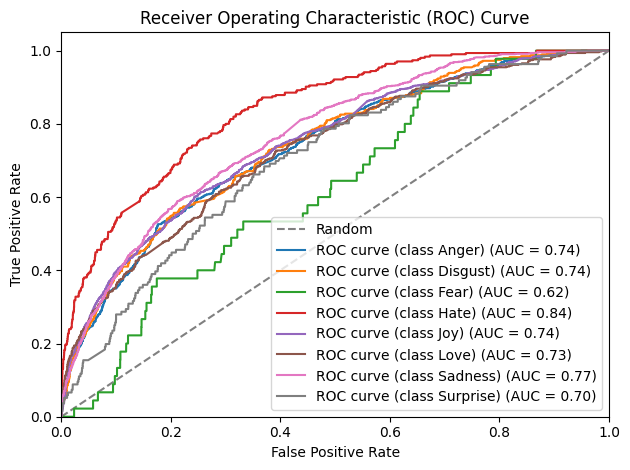

In [ ]:
evaluate_model(mnb_classifier, X_test, y_test, label_encoder)

## **GNB**

In [ ]:
from sklearn.naive_bayes import GaussianNB

gnb_classifier = GaussianNB()

gnb_classifier.fit(X_train.toarray(), y_train)

In [ ]:
y_pred_gnb = gnb_classifier.predict(X_test.toarray())

accuracy_gnb = accuracy_score(y_test, y_pred_gnb)
print(f'Gaussian Naive Bayes Accuracy: {accuracy_gnb:.4f}')


Gaussian Naive Bayes Accuracy: 0.0988


### **Call Function Evaluate**

Accuracy: 0.0988
Precision: 0.3065
Recall: 0.0988
F1-Score: 0.1102
Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.10      0.15       711
           1       0.23      0.10      0.14       395
           2       0.01      0.40      0.02        45
           3       0.20      0.26      0.23       305
           4       0.40      0.03      0.06      1593
           5       0.15      0.22      0.17       462
           6       0.40      0.06      0.10       928
           7       0.04      0.28      0.07       136

    accuracy                           0.10      4575
   macro avg       0.21      0.18      0.12      4575
weighted avg       0.31      0.10      0.11      4575



<ipython-input-38-145de915995e>:42: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='gray', label='Random')


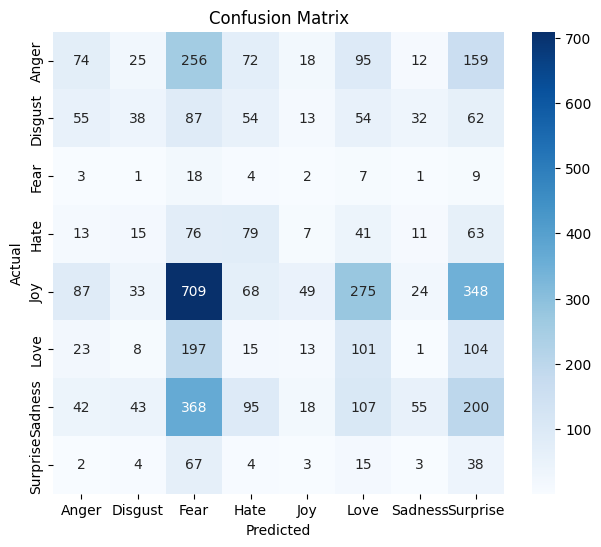

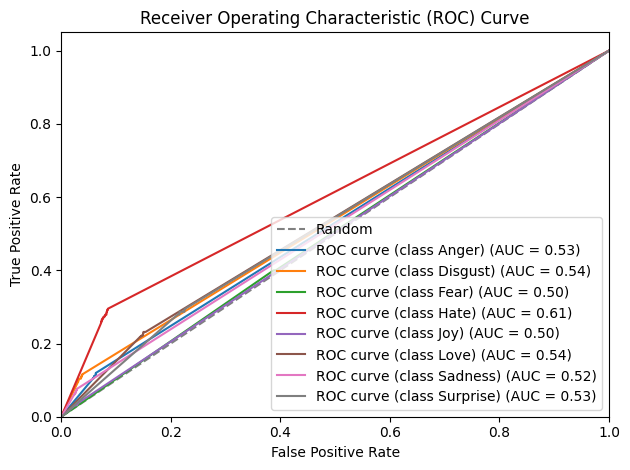

In [ ]:
evaluate_model(gnb_classifier, X_test.toarray(), y_test, label_encoder)